# DSCI 100 Group Project Proposal

Insert some introduction here

In [7]:
### Run this cell before continuing.
library(plyr)
library(dplyr)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [8]:
stroke_data <- read_csv("data/healthcare-dataset-stroke-data.csv")
stroke_data

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
37544,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
44679,Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


To view what correlation various factors have on developing stroke, we will plot three scatter graphs: age vs. average glucose level, age vs. BMI, and BMI vs. average glucose level. These three variables were chosen because they were continuous measurements and are closely related to the develpopment of stroke. 

In [9]:
stroke_data_final <- stroke_data |>
                    mutate (stroke = as.factor(stroke),
                           bmi = as.numeric(bmi))
stroke_data_final
stroke_split <- initial_split(stroke_data_final, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split) 

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,NA,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
37544,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
44679,Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


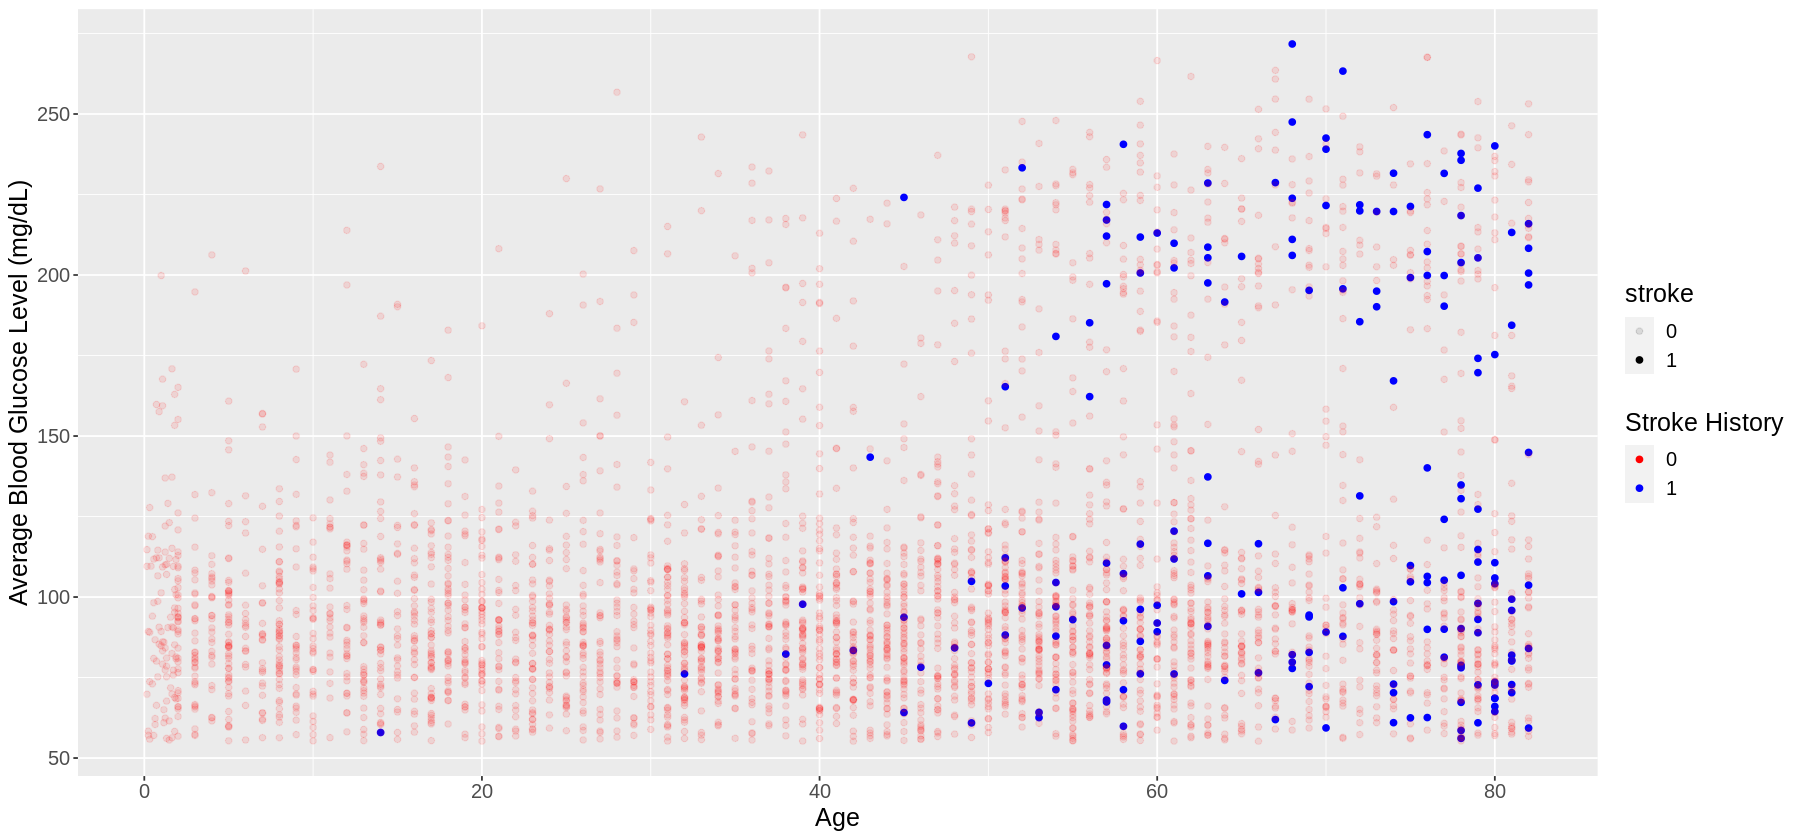

In [10]:
age_vs_glucose <- ggplot (stroke_train, aes(x=age, y=avg_glucose_level, color= stroke))+
                geom_point(aes(alpha = stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Age", y="Average Blood Glucose Level (mg/dL)", color = "Stroke History")+
                theme(text = element_text(size = 15))
options(repr.plot.width = 15, repr.plot.length = 20)

age_vs_glucose

Warning message:
“Removed 152 rows containing missing values (geom_point).”


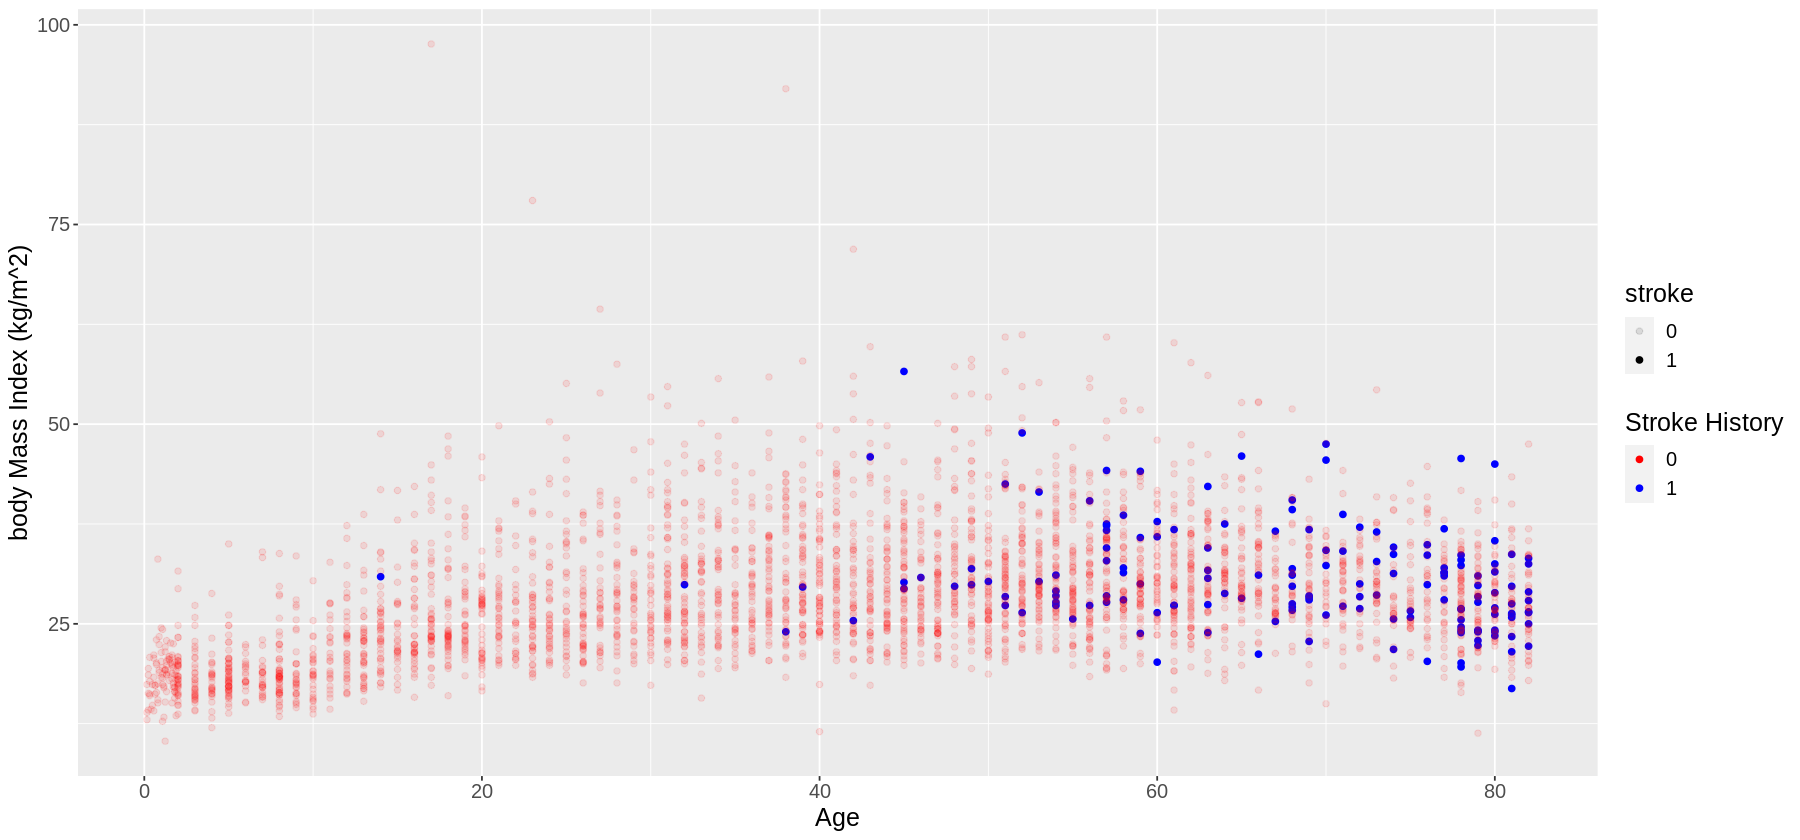

In [11]:
age_vs_bmi <- ggplot (stroke_train, aes(x=age, y=bmi, color= stroke))+
                geom_point(aes(alpha = stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Age", y="body Mass Index (kg/m^2)", color = "Stroke History")+
                theme(text = element_text(size = 15))
options(repr.plot.width = 15, repr.plot.length = 20)

age_vs_bmi

Warning message:
“Removed 152 rows containing missing values (geom_point).”


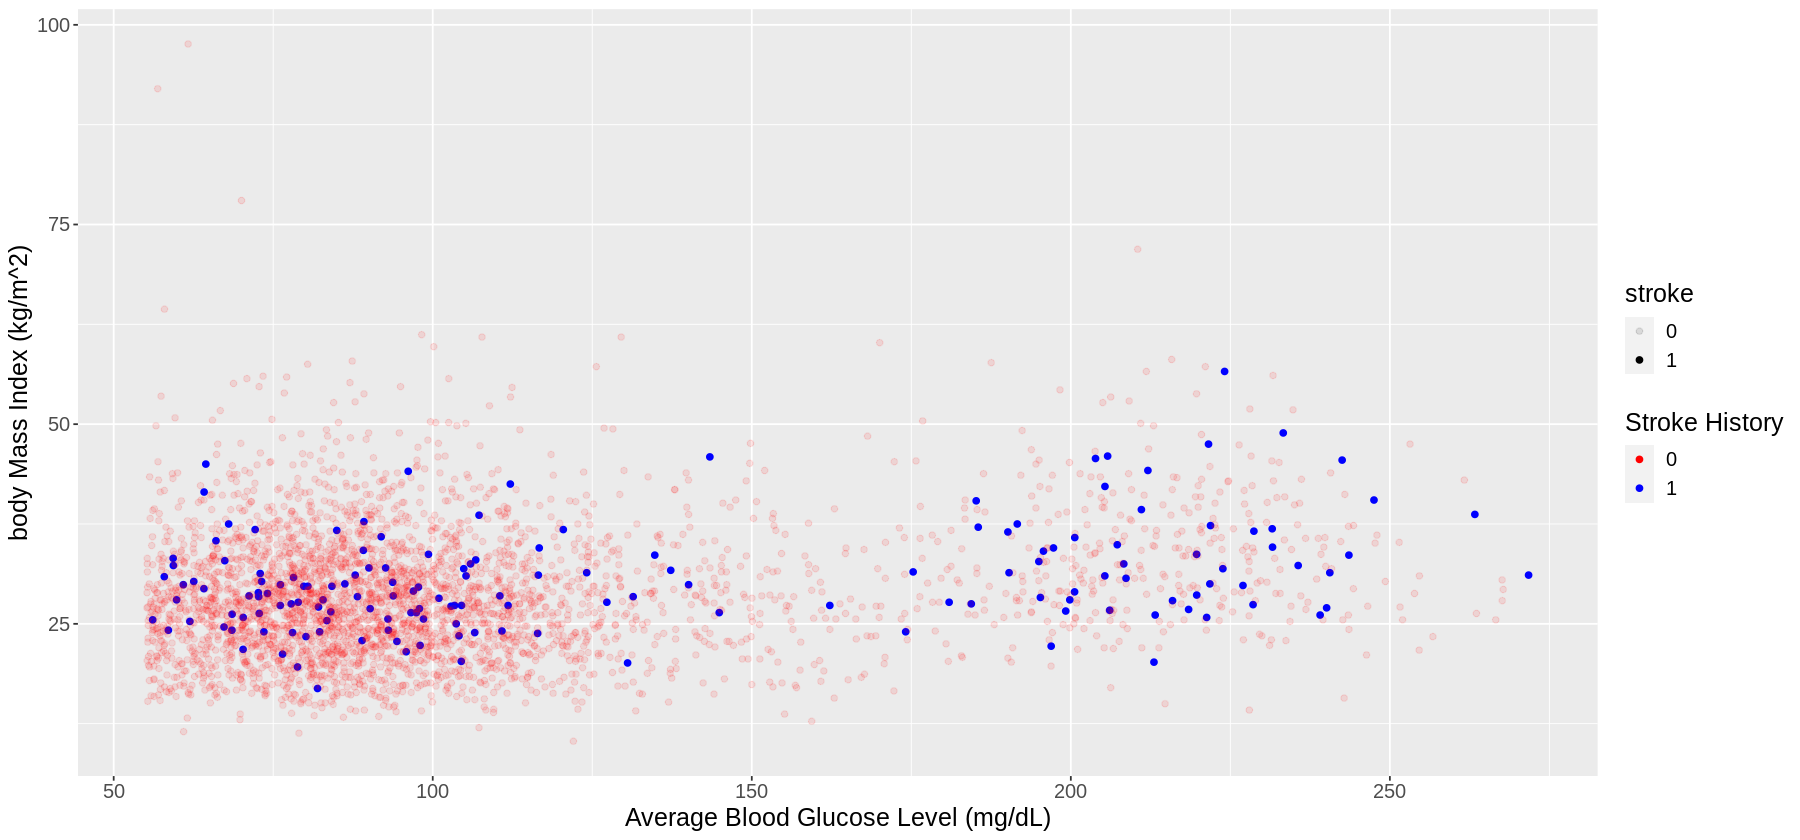

In [12]:
avg_glucose_vs_bmi <- ggplot (stroke_train, aes(x=avg_glucose_level, y=bmi, color= stroke))+
                geom_point(aes(alpha = stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Average Blood Glucose Level (mg/dL)", y="body Mass Index (kg/m^2)", color = "Stroke History")+
                theme(text = element_text(size = 15))
options(repr.plot.width = 15, repr.plot.length = 20)

avg_glucose_vs_bmi

The tables below show the min and the max of each continous feature when a person has or has not a stroke

In [47]:
continous_factors <- select(stroke_train, bmi,avg_glucose_level,age,stroke)

factors_with_stroke <- filter(continous_factors, stroke == 1)
factors_without_stroke <- filter(continous_factors, stroke == 0)


min_max <- list(
  min = ~min(.x, na.rm = TRUE), 
  max = ~max(.x, na.rm = TRUE)
)

avg <- list(
  avg = ~mean(.x, na.rm = TRUE)
)



factors_with_stroke |> summarise(across(where(is.numeric), min_max))
factors_without_stroke |> summarise(across(where(is.numeric), min_max))




bmi,avg_glucose_level,age,stroke
<dbl>,<dbl>,<dbl>,<fct>
36.6,228.69,67,1
NA,202.21,61,1
32.5,105.92,80,1
⋮,⋮,⋮,⋮
30.9,57.93,14,1
NA,87.80,71,1
19.6,78.81,78,1


bmi,avg_glucose_level,age,stroke
<dbl>,<dbl>,<dbl>,<fct>
39.2,87.96,58,0
17.6,110.89,8,0
35.9,69.04,70,0
⋮,⋮,⋮,⋮
40.0,125.20,81,0
25.6,166.29,51,0
26.2,85.28,44,0


bmi_min,bmi_max,avg_glucose_level_min,avg_glucose_level_max,age_min,age_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16.9,56.6,56.11,271.74,14,82


bmi_min,bmi_max,avg_glucose_level_min,avg_glucose_level_max,age_min,age_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10.3,97.6,55.22,267.76,0.16,82


bmi_avg,avg_glucose_level_avg,age_avg
<dbl>,<dbl>,<dbl>
30.64088,133.2679,67.74731


bmi_avg,avg_glucose_level_avg,age_avg
<dbl>,<dbl>,<dbl>
28.56581,104.8132,41.91229


With stroke: Bmi,With stroke: Avg Glucose,With stroke: Age,Without stroke: Bmi,Without stroke: Avg Glucose,Without stroke: Age
<int>,<int>,<int>,<int>,<int>,<int>
27,0,27,125,0,0


The tables below show the avg of each continous feature when a person has or has not a stroke

In [ ]:
factors_with_stroke |> summarise(across(where(is.numeric), avg))
factors_without_stroke |> summarise(across(where(is.numeric), avg))

The table below shows how many cells with missing data are present in each column

In [ ]:
stroke_bmi <- sum(is.na(factors_with_stroke$bmi))
stroke_avg_glucos <- sum(is.na(factors_with_stroke$avg_glucose_level))
stroke_age <- sum(is.na(factors_with_stroke$age))
no_stroke_bmi <- sum(is.na(factors_without_stroke$bmi))
no_stroke_averge_glucose <- sum(is.na(factors_without_stroke$avg_glucose_level))
no_stroke_age <- sum(is.na(factors_without_stroke$age))

missing_data <- tibble("With stroke: Bmi" = stroke_bmi, "With stroke: Avg Glucose" = stroke_avg_glucos, "With stroke: Age" = stroke_bmi, 
            "Without stroke: Bmi" = no_stroke_bmi, "Without stroke: Avg Glucose" = no_stroke_averge_glucose, "Without stroke: Age" = no_stroke_age)
missing_data